In [1]:
from __future__ import division

import pandas as pd
import numpy as np
#import html2text
from datetime import date
import random
import os

#Packages for pulling text data 
from urllib.request import urlopen  # the lib that handles the url stuff
from bs4 import BeautifulSoup
import pandas.io.data as web
from pandas.tseries.offsets import BDay

#Packages for text data processing
import nltk, re, pprint
#nltk.download()
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer

#Packages for statistical learning 
from sklearn.preprocessing import normalize as Normal
from sklearn import svm
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline

import imp

import Text_Analytics as TA

C:\Users\ziyi\Anaconda3\lib\site-packages\pandas\io\data.py:35: FutureWarning: 
The pandas.io.data module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


In [2]:
#from imp import reload 
imp.reload(TA)

<module 'Text_Analytics' from 'C:\\Users\\ziyi\\Desktop\\Inde project\\Independent Study Anseri-20170120T004329Z\\Independent Study Anseri\\Code repo\\Text_Analytics.py'>

In [3]:
#Setup working directory 
os.chdir("C:/Users/ziyi/Desktop/Inde project/Independent Study Anseri-20170120T004329Z/Independent Study Anseri")

#Download Data 
df=pd.read_excel('8K data/8K_Info.xlsx')
df=df[-pd.isnull(df.Text)] #remove invalid rows
Events_df=pd.read_csv("8K data/events_Info.csv",index_col=0)

#Setup Item Parameters 
Item="2.02"
item="ITEM"+" "+Item

#Setup Output Parameters
itemb="202"
add1='8K Data/tfidf_ITEM'+itemb+"_Info.csv"
add2='8K Data/keyword_ITEM'+itemb+"_Info.csv"
add3='8K Data/SPCA_ITEM'+itemb+'_Info.csv'

In [4]:
ITEM_list=TA.get_event_doc(Events_df,item)

In [5]:
ITEM_docs=df.loc[ITEM_list]

In [6]:
ITEM_docs["ITEM_text"]=ITEM_docs.Text.apply(lambda x:TA.get_event_text(x,item))

In [7]:
ITEM_docs.drop("Text",axis=1,inplace=True)

In [8]:
ITEM_docs.head()

,Unnamed: 0,CIK,Company Name,Form Type,Date Filed,Filename,Ticker,ITEM_text
13,3736,1009626,BROCADE COMMUNICATIONS SYSTEMS INC,8-K,2/19/2015,edgar/data/1009626/0001009626-15-000013.txt,BRCD,ITEM 2.02 RESULTS OF OPERATIONS AND FINANCIAL ...
52,4884,1013462,ANSYS INC,8-K,2/26/2015,edgar/data/1013462/0001171843-15-001041.txt,ANSS,ITEM 2.02. RESULTS OF OPERATIONS AND FINANCIAL...
101,12698,1032220,MAXIMUS INC,8-K,2/9/2015,edgar/data/1032220/0001157523-15-000475.txt,MMS,ITEM 2.02 RESULTS\n OF OPERATIONS...
134,14012,103730,VISHAY INTERTECHNOLOGY INC,8-K,2/5/2015,edgar/data/103730/0000103730-15-000002.txt,VSH,ITEM 2.02 – RESULTS OF OPERATIONS AND FINANCIA...
170,14430,1038074,SILICON LABORATORIES INC,8-K,2/4/2015,edgar/data/1038074/0001104659-15-006485.txt,SLAB,ITEM 2.02. RESULTS OF OPERATIONS AND FINANCIAL...


## Event Text Processing

In [10]:
ITEM_docs["ITEM_words"]=ITEM_docs["ITEM_text"]
for i,row in ITEM_docs.iterrows():
    ITEM_docs.loc[i,"ITEM_words"]=TA.clean_text(row["ITEM_text"],row["Company Name"])

In [11]:
ITEM_docs["ITEM_nouns"]=ITEM_docs.ITEM_words.apply(lambda x:TA.get_noun(x))

## Bag of words

In [12]:
#get bag of words
#vectorizer = CountVectorizer( analyzer='word',ngram_range=(1,1), max_df=0.9, min_df=0.05, max_features=500)
#vectorizer = CountVectorizer( analyzer='word',ngram_range=(1,1),max_df=0.8, stop_words="english", max_features=500)
vectorizer = CountVectorizer( analyzer='word',tokenizer = None, preprocessor = None,stop_words = None,max_features = 5000)
X=vectorizer.fit_transform(ITEM_docs.ITEM_nouns.tolist())
print (len(vectorizer.get_feature_names())) #1171 features 
print (X.toarray())
print ((np.sum(X.toarray(),0)))

1062
[[0 0 0 ..., 2 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
[  1  65   2 ..., 314   1   1]


C:\Users\ziyi\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


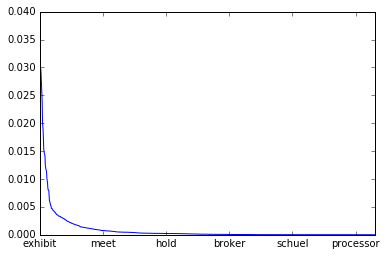

In [13]:
ITEM_dict=pd.DataFrame({"Freq":[0]*len(vectorizer.get_feature_names())},index=vectorizer.get_feature_names())
ITEM_dict["Freq"]=np.sum(X.toarray(),0)
ITEM_dict["Freq_pct"]=ITEM_dict["Freq"]/sum(ITEM_dict["Freq"])

ITEM_dict=ITEM_dict.sort(['Freq'], ascending=[False])

ITEM_dict["Freq_pct"].plot(x=ITEM_dict.index,y="Freq_pct")

In [14]:
ITEM_dict[ITEM_dict["Freq_pct"]>0.001]

,Freq,Freq_pct
exhibit,2607,0.038392
item,2052,0.030219
result,2030,0.029895
press,2004,0.029512
releas,1907,0.028084
compani,1791,0.026375
financi,1736,0.025566
gaap,1628,0.023975
file,1385,0.020396
act,1325,0.019513


In [15]:
# get tf-idf table
transformer = TfidfTransformer(smooth_idf=True)
tf_idf=transformer.fit_transform(X)
tfidf_df=pd.DataFrame(tf_idf.toarray(), index=ITEM_docs.index, columns=vectorizer.get_feature_names())
tfidf_df[['CIK','Company Name','Date Filed']]=ITEM_docs[['CIK','Company Name','Date Filed']].copy()
tfidf_df.head()

,abandon,abil,abl,acceler,accept,access,accompani,accord,accordingli,account,...,write,writedown,wsa,www,year,yield,york,CIK,Company Name,Date Filed
13,0.0,0.0,0.0,0.0,0.0,0.0,0.214879,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.100406,0.135175,0.0,0.0,1009626,BROCADE COMMUNICATIONS SYSTEMS INC,2/19/2015
52,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1013462,ANSYS INC,2/26/2015
101,0.0,0.0,0.0,0.0,0.0,0.0,0.222296,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,1032220,MAXIMUS INC,2/9/2015
134,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026029,0.01473,0.019554,...,0.0,0.0,0.0,0.000000,0.006877,0.0,0.0,103730,VISHAY INTERTECHNOLOGY INC,2/5/2015
170,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.067758,0.00000,0.000000,...,0.0,0.0,0.0,0.000000,0.053711,0.0,0.0,1038074,SILICON LABORATORIES INC,2/4/2015


In [17]:
Key_df=TA.Doc_Keywords(ITEM_docs, tfidf_df[vectorizer.get_feature_names()], 10)
Key_df

,CIK,Company Name,Date Filed,0,1,2,3,4,5,6,7,8,9
13,1009626,BROCADE COMMUNICATIONS SYSTEMS INC,2/19/2015,remark,regard,estim,compani,result,januari,accompani,prepar,slide,quarter
52,1013462,ANSYS INC,2/26/2015,februari,remark,document,exhibit,date,registr,copi,press,releas,item
101,1032220,MAXIMUS INC,2/9/2015,result,slide,call,confer,item,form,accompani,transcript,text,respect
134,103730,VISHAY INTERTECHNOLOGY INC,2/5/2015,dilut,share,stock,convers,convert,price,princip,debentur,ep,comput
170,1038074,SILICON LABORATORIES INC,2/4/2015,financi,result,measur,supplement,gaap,inform,februari,addit,press,investor
214,1056696,MANHATTAN ASSOCIATES INC,2/3/2015,adjust,acquisit,share,incom,measur,cost,gaap,compens,perform,competitor
246,1062047,CONVERGYS CORP,2/18/2015,gaap,press,releas,februari,speak,therein,date,affair,statement,cautionari
258,1078075,NETSCOUT SYSTEMS INC,1/22/2015,januari,compani,exhibit,hold,expressli,topic,herebi,file,intent,futur
298,1111928,IPG PHOTONICS CORP,2/9/2015,februari,form,regist,extent,act,file,schedul,result,preliminari,corpor
299,1111928,IPG PHOTONICS CORP,2/20/2015,corpor,februari,exhibit,act,forth,file,conditionon,form,text,specif


In [92]:
tfidf_df.to_csv(add1)
Key_df.to_csv(add2)

## Sparse PCA

In [83]:
#tfidf_df_indexed=pd.read_csv(Out_add1, index_col=0)
#tfidf_df=tfidf_df_indexed[vectorizer.get_feature_names()]
#tfidf_df.head()

In [18]:
from sklearn import decomposition
SPCA=decomposition.SparsePCA(n_components=30,alpha=0.3,ridge_alpha=0)
SPCA.fit(tfidf_df.iloc[:,:-3])
SPCA.components_

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [19]:
np.sum(SPCA.components_!=0,axis=1)

array([18, 17,  7, 11, 18,  7, 12, 12, 12,  3,  2,  3, 31, 25,  2,  2, 21,
        9,  2,  9, 22,  7,  2,  5, 17,  3, 16, 10, 12,  9])

In [20]:
SPCA.error_[-1]

147.69228346998796

In [22]:
SPCA_df=pd.DataFrame(SPCA.components_, columns=tfidf_df.iloc[:,:-3].columns)
for i,row in SPCA_df.iterrows():
    print(TA.get_Keywords(row,20))

['pleas', 'plu', 'pend', 'perform', 'period', 'perman', 'person', 'personnel', 'pham', 'phrase', 'pierc', 'place', 'plan', 'plant', 'playback', 'pc', 'pre', 'power', nan, nan]
['exclud', 'margin', 'expens', 'non', 'tax', 'gaap', 'asset', 'accord', 'loss', 'impact', 'busi', 'acquir', 'intang', 'settlement', 'effect', 'relat', 'amort', nan, nan, nan]
['item', 'result', 'financi', 'statement', 'condit', 'exhibit', 'end', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['phrase', 'pham', 'playback', 'plant', 'plan', 'place', 'pierc', 'plu', 'period', 'perman', 'perform', nan, nan, nan, nan, nan, nan, nan, nan, nan]
['dilut', 'stock', 'outstand', 'calcul', 'number', 'share', 'ep', 'comput', 'method', 'price', 'princip', 'debentur', 'market', 'earn', 'amount', 'convers', 'convert', 'option', nan, nan]
['place', 'pierc', 'plu', 'pleas', 'playback', 'plant', 'plan', nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
['end', 'webcast', 'confer', 'refer', 'respect'

In [23]:
col_names=['Topic'+str(i) for i in np.arange(0,SPCA_df.shape[0])]
Topics=pd.DataFrame(SPCA.transform(tfidf_df.iloc[:,:-3]),index=tfidf_df.index, columns=col_names)
Topics[['CIK','Company Name','Date Filed']]=df[['CIK','Company Name','Date Filed']].copy()

In [24]:
Topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,CIK,Company Name,Date Filed
13,-0.027431,-0.001518,0.040688,-0.000613,0.000079,-0.000087,0.033019,0.136565,-0.027292,0.005552,...,-0.002014,0.015820,0.000154,-0.000534,-0.014256,0.024478,0.031448,1009626,BROCADE COMMUNICATIONS SYSTEMS INC,2/19/2015
52,0.001659,0.000360,0.033581,-0.001812,-0.000010,-0.000757,-0.001349,0.199353,-0.038585,-0.002939,...,0.000298,0.075780,0.000028,-0.067298,-0.006162,-0.005040,-0.011015,1013462,ANSYS INC,2/26/2015
101,-0.003502,-0.000465,0.043901,0.000349,0.000048,0.001942,0.209616,-0.000635,-0.028588,0.108631,...,0.000082,0.005996,-0.000075,0.000352,-0.005745,0.002507,-0.002315,1032220,MAXIMUS INC,2/9/2015
134,-0.001821,0.001423,0.001746,-0.000366,0.241038,-0.000710,0.001736,0.000899,-0.002841,0.003299,...,-0.000075,0.001430,0.000044,-0.002554,-0.001758,0.000746,0.000557,103730,VISHAY INTERTECHNOLOGY INC,2/5/2015
170,-0.018567,0.056983,0.020128,0.002399,-0.000517,0.000053,-0.004533,-0.000506,-0.032038,-0.001366,...,-0.000351,0.022619,0.000099,0.001924,0.001840,0.039087,0.004402,1038074,SILICON LABORATORIES INC,2/4/2015
214,-0.004564,0.037881,0.011083,0.001684,0.016509,0.000428,-0.001174,0.001151,-0.014318,0.003003,...,-0.000211,0.004652,0.000004,0.000341,-0.006322,0.006469,0.000798,1056696,MANHATTAN ASSOCIATES INC,2/3/2015
246,-0.038192,0.058398,0.028948,0.000578,0.000170,-0.001445,-0.001705,0.000610,-0.072861,0.034095,...,0.043681,0.031272,0.000279,-0.000825,-0.000012,0.013785,0.018030,1062047,CONVERGYS CORP,2/18/2015
258,-0.042850,-0.000412,0.025982,-0.007304,-0.000853,0.000612,0.002690,-0.000477,-0.036741,-0.005117,...,-0.002872,0.050124,0.000204,-0.005152,0.008460,0.045941,0.050914,1078075,NETSCOUT SYSTEMS INC,1/22/2015
298,-0.049825,0.015354,0.033533,0.002522,0.000138,-0.001212,-0.001925,-0.001166,-0.040208,0.049688,...,0.096432,0.014753,0.000331,-0.010476,-0.037426,-0.013845,0.062807,1111928,IPG PHOTONICS CORP,2/9/2015
299,-0.060607,0.001305,0.033753,-0.004628,-0.000014,-0.000879,-0.001076,-0.001821,-0.029980,0.086866,...,0.161517,0.027352,0.000374,-0.000121,-0.009779,-0.006109,0.106137,1111928,IPG PHOTONICS CORP,2/20/2015


In [93]:
Topics.to_csv(add3)